# Image Classification: Humon Emotions

## Preface
1. Create and train model across all 7 major emotions identified in the [KDEF dataset](http://kdef.se/home/aboutKDEF.html).
2. Fine-tune the model by altering learning and epochs till the training loss(TL) and validation loss(VL) and error rates in order.
3. Create simple webapp to predict emotion when given image of human face.
4. Test the model against hand-picked set of Google images

(UNFINISHED...)

## Imports 

First include essential instructions and libraries.

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai import *
from fastai.vision import *

In [ ]:
plt.style.use(['dark_background'])

## Paths

In [ ]:
DATA_PATH = Config.data_path()
PATH = DATA_PATH/'kdef/kdef_and_akdef/KDEF'
PATH.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/kdef/kdef_and_akdef/KDEF/AF34'),
 PosixPath('/home/jupyter/.fastai/data/kdef/kdef_and_akdef/KDEF/AM28'),
 PosixPath('/home/jupyter/.fastai/data/kdef/kdef_and_akdef/KDEF/AF01'),
 PosixPath('/home/jupyter/.fastai/data/kdef/kdef_and_akdef/KDEF/AF04'),
 PosixPath('/home/jupyter/.fastai/data/kdef/kdef_and_akdef/KDEF/AM33')]

## Data Preparation

In [ ]:
#db0 = ImageItemList.from_folder(PATH); db0

In [ ]:
#_inner = lambda o: re.search("S.", o.parts[-1])
#db1 = db0.filter_by_func(func=_inner); db1

In [ ]:
#db2 = db1.random_split_by_pct(); db2

In [ ]:
#pat = r"\w{4}(\w{2})\w{1,2}.JPG$"
#db3 = db2.label_from_re(pat=pat); db3

In [ ]:
tfms = get_transforms()
_inner = lambda o: re.search(r"S.JPG$", o.parts[-1])
pat = r"\w{4}(\w{2})\w{1,2}.JPG$"

In [ ]:
src = (ImageItemList.from_folder(PATH)
       .filter_by_func(func=_inner)
       .random_split_by_pct()
       .label_from_re(pat))

In [ ]:
data = (src.transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

In [ ]:
data, data.classes, data.c

(ImageDataBunch;
 
 Train: LabelList
 y: CategoryList (784 items)
 [Category SU, Category AN, Category NE, Category DI, Category SA]...
 Path: /home/jupyter/.fastai/data/kdef/kdef_and_akdef/KDEF
 x: ImageItemList (784 items)
 [Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562)]...
 Path: /home/jupyter/.fastai/data/kdef/kdef_and_akdef/KDEF;
 
 Valid: LabelList
 y: CategoryList (196 items)
 [Category SA, Category AN, Category SA, Category SA, Category AF]...
 Path: /home/jupyter/.fastai/data/kdef/kdef_and_akdef/KDEF
 x: ImageItemList (196 items)
 [Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562), Image (3, 762, 562)]...
 Path: /home/jupyter/.fastai/data/kdef/kdef_and_akdef/KDEF;
 
 Test: None, ['AF', 'AN', 'DI', 'HA', 'NE', 'SA', 'SU'], 7)

## Sanity Check

In [ ]:
data.sanity_check()

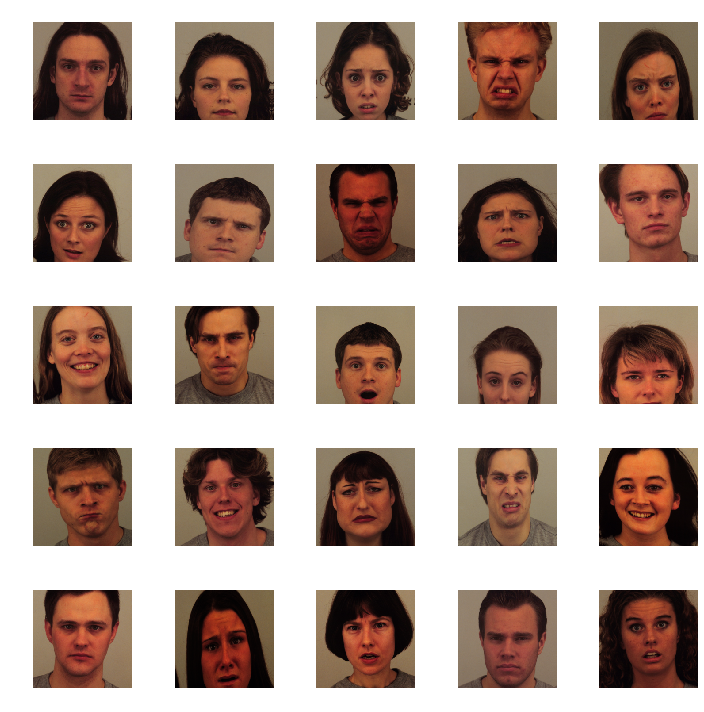

In [ ]:
data.show_batch(rows=5, figsize=(10,10))

## Train

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


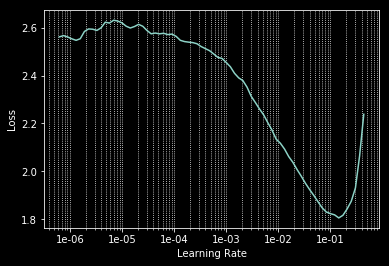

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

The logic here is to pick the sharpest downward slope, which is `lr=2e-2`

In [ ]:
lr=2e-2

In [ ]:
learn.fit_one_cycle(16,lr)

epoch,train_loss,valid_loss,error_rate
1,1.998875,1.422893,0.551020
2,1.549697,1.200254,0.362245
3,1.231818,0.859772,0.270408
4,1.049565,1.419980,0.489796
5,0.940423,3.551693,0.693878
6,0.857666,0.969090,0.234694
7,0.773695,0.743607,0.250000
8,0.680308,0.637418,0.224490
9,0.594409,0.602094,0.219388
10,0.534008,0.326888,0.107143


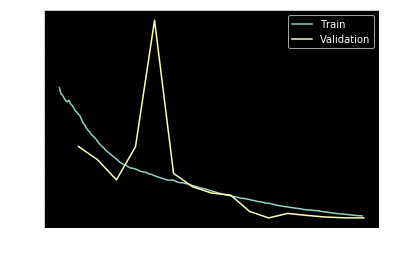

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage1-224-2en2-16eps')

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


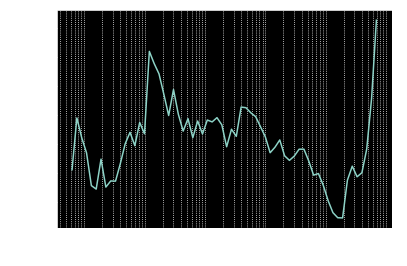

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [ ]:
lr=6e-3

In [ ]:
learn.fit_one_cycle(16,lr)

epoch,train_loss,valid_loss,error_rate
1,0.152496,0.218997,0.045918
2,0.134354,0.227038,0.045918
3,0.147498,0.221622,0.051020
4,0.148096,0.213359,0.056122
5,0.152995,0.190308,0.056122
6,0.155691,0.242511,0.056122
7,0.147329,0.217399,0.056122
8,0.139523,0.355141,0.127551
9,0.141929,0.202149,0.051020
10,0.145603,0.245040,0.051020


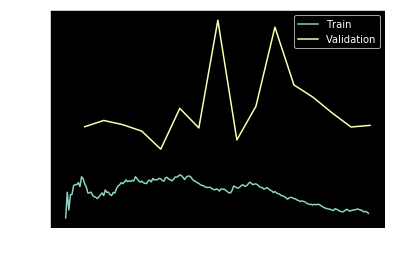

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage2-224-6en3-16eps')

## Fine-tune

In [ ]:
#learn.load('stage2-224-6en3-16eps');
learn.load('stage1-224-2en2-16eps');

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


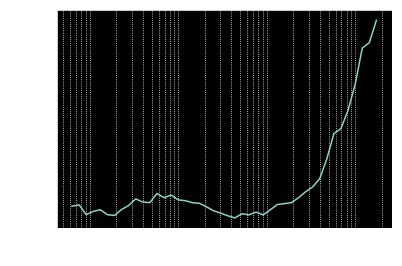

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [ ]:
lrs=slice(1e-4)

In [ ]:
learn.fit_one_cycle(10,lrs)

epoch,train_loss,valid_loss,error_rate
1,0.103708,0.217595,0.045918
2,0.127313,0.212494,0.040816
3,0.132879,0.203120,0.040816
4,0.130899,0.189267,0.045918
5,0.125578,0.165421,0.040816
6,0.121901,0.172991,0.045918
7,0.114141,0.170485,0.040816
8,0.113926,0.165379,0.035714
9,0.116019,0.167754,0.030612
10,0.112664,0.167262,0.030612


In [ ]:
#learn.save('stage3-unf-224-s1en4-eps10')
learn.save('stage3-unf-224-s1en4-eps10-fr-stage1')

## Interpret

In [ ]:
learn.load('stage3-unf-224-s1en4-eps10-fr-stage1');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

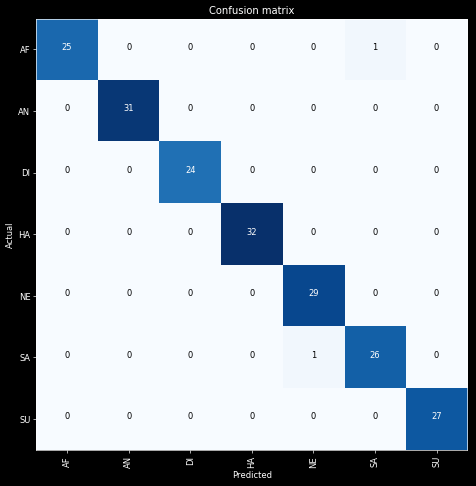

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [ ]:
interp.most_confused(min_val=0)

[('AF', 'SA', 1), ('SA', 'NE', 1)]

So after stage 3, the model has a 3.06% error rate and is mostly confused between `sad` and `disgusting`. Let's view the most confusing images to see if it baffles human perception too.

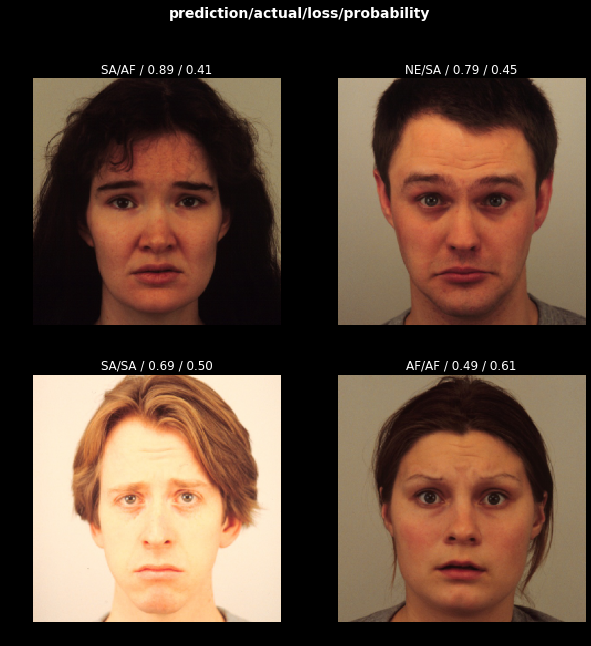

In [ ]:
interp.plot_top_losses(4, figsize=(10,10))

In [ ]:
_,ids = interp.top_losses(k=2)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, tta=True)

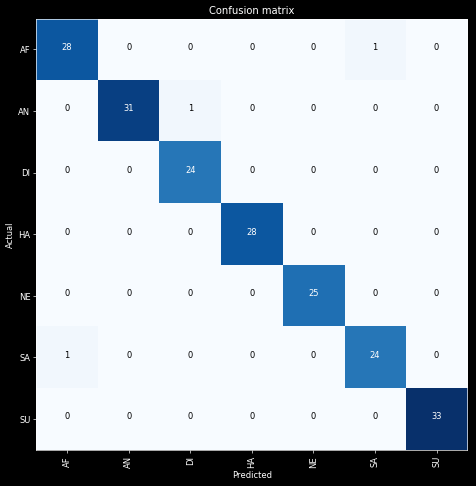

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

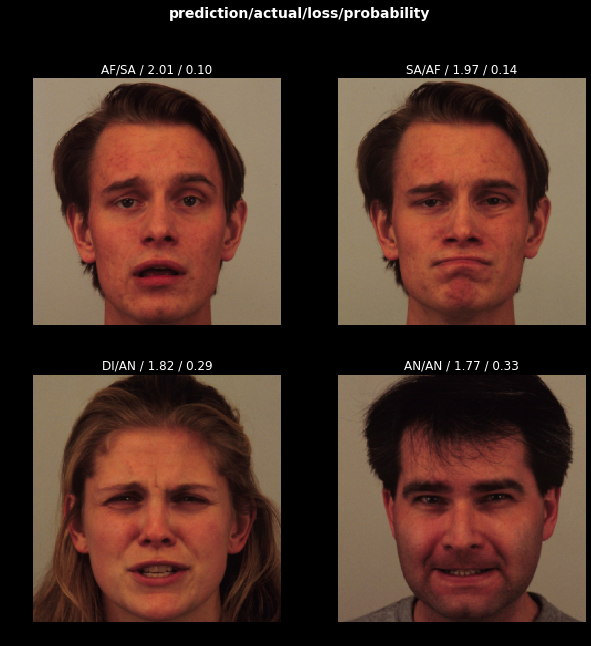

In [ ]:
interp.plot_top_losses(4, figsize=(10,10))

## Reproduce Grad-CAM paper

I am going to implement and reproduce [Grad-CAM](https://arxiv.org/abs/1610.02391) papar. The idea is to obtain a heatmap of the important areas of the images for the classifier.

### Setup

In [ ]:
#export
from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage

In [ ]:
learn,img,imgx,y=None,None,None,None
gc.collect()

0

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.load('stage3-unf-224-s1en4-eps10-fr-stage1');

In [ ]:
img,y = data.valid_ds.x[7],data.valid_ds.y[7]
imgx = learn.data.one_item(img)[0]

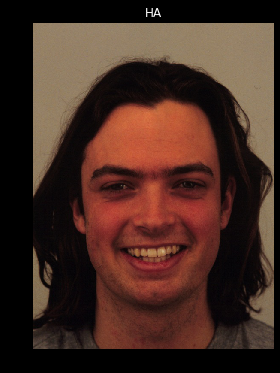

In [ ]:
img.show(figsize=(6,6), title=y)

### Grad CAM

See this [paper](https://arxiv.org/pdf/1610.02391.pdf) for detail. The idea is to take the ***outputs of the last "convolutional layer"***, here is a stack of 7x7 feature maps, then weigh them by their importance to the given class using an average of the gradients of those layers w.r.t. the class score vector.

In [ ]:
last_conv_block = learn.model[0][-1][-1]; last_conv_block

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

We therefore need to set up two hooks:
- for the feature maps
- for the gradients

Then we linearly combine the feature maps using a reduced version of the gradient to obtain the heatmap

In [ ]:
#export
def hooked_acts_grads(m,target,xb,y):
    with hook_output(target) as hook_a:
        with hook_output(target, grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(y)].backward()
    return hook_a,hook_g

In [ ]:
learn.model.eval();
learn.model.zero_grad();
hook_a,hook_g = hooked_acts_grads(learn.model,last_conv_block,imgx,y)

In [ ]:
hook_a.stored.shape, [o.shape for o in hook_g.stored]

(torch.Size([1, 512, 7, 7]), [torch.Size([1, 512, 7, 7])])

We've now run our forward and backward passes, we only need to combine the gradients and feature maps to obtain our heat map

In [ ]:
grads = hook_g.stored[0][0].cpu().numpy()
feats = hook_a.stored[0].cpu().numpy()

In [ ]:
grads.shape, feats.shape

((512, 7, 7), (512, 7, 7))

In [ ]:
grads_mean = grads.mean((1,2)).reshape(-1)
grads_sum  = grads.sum((1,2)).reshape(-1)

We can either choose `mean` or `sum` to calulate the weighs because the `minmax_normalization` of them are close enough

In [ ]:
#export
def minmax_normalize(x):
    if isinstance(x, np.ndarray): return (x - np.min(x))/(np.max(x) - np.min(x))
    else:                return (x - torch.min(x))/(torch.max(x) - torch.min(x))

In [ ]:
np.allclose(minmax_normalize(grads_mean), minmax_normalize(grads_sum))

True

In [ ]:
grads_mean.shape, feats.shape

((512,), (512, 7, 7))

In [ ]:
weighed_feats = np.maximum(0, np.einsum('i,ijk->jk',grads_mean,feats))

In [ ]:
weighed_feats.shape

(7, 7)

In [ ]:
#export
def upsample(x,size):
    scale_mult = np.array(size)/x.shape[0]
    upsampled  = scipy.ndimage.zoom(x, scale_mult)
    return upsampled

In [ ]:
hmap = minmax_normalize(upsample(weighed_feats,size=224))
base = Image(learn.data.denorm(imgx.data.squeeze()))

In [ ]:
plot_heatmap(base,heatmap,figsize=(6,6))

In [ ]:
imgx.shape, img.shape, heatmap.shape

(torch.Size([1, 3, 224, 224]), torch.Size([3, 762, 562]), (224, 224))

In [ ]:
#export
def plot_heatmap(base,top,figsize=(6,6)):
    _,ax = plt.subplots(figsize=figsize)
    base.show(ax)
    ax.imshow(top,alpha=.6,interpolation='bilinear',cmap='magma')

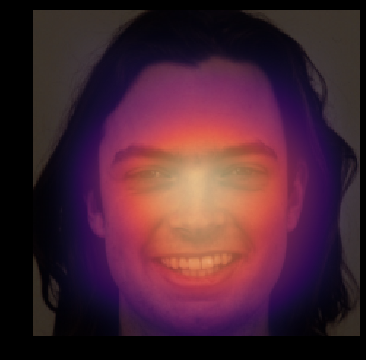

In [ ]:
plot_heatmap(base, hmap)

### Guided Backprop

So... our heatmap is nicely plotted but unfortunately not very fine-grained. We are constrained by the resolution of the feature maps (in our case 7x7)
A first idea would be to naively compute the backprop the gradients of our "forced score" all the way to the image, and see which pixel has higher gradients. So let's do this

In [ ]:
imgx.requires_grad_()
learn.model.eval()
learn.model.zero_grad()
out = learn.model(imgx)

In [ ]:
out[0,int(y)].backward()

In [ ]:
normal_grad = Image(minmax_normalize(imgx.grad).squeeze())

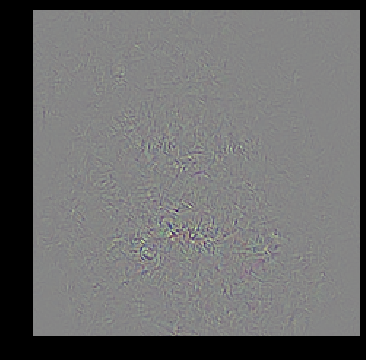

In [ ]:
normal_grad.show(figsize=(6,6))

Honestly, this looks horrifying useless. This is because the various neurons interfere with each other during the backpropagation. The [Strving for Simplicity: the All Convolutional Net](https://arxiv.org/abs/1412.6806) paper introduced the concept of ***Guided Backpropagation***. The idea, avoiding interference is to simply retain the positive contributions to the gradient while back-propaagating, thereby avoiding all interference.

- We therefore locate all the **relu modules** in the model

In [ ]:
relu_blocks = [o for o in flatten_model(learn.model) if isinstance(o,nn.ReLU)]

- **Clamp all negative gradients** at each ReLU layer

In [ ]:
#export
def gradient_clamping(module,input,ouput):
    for grad in input: torch.clamp_(grad,min=0.0)

- Hook up our callback function to target blocks. And we will now backprop and observe the result

In [ ]:
# hook for guided backproph
hooked_relu = Hooks(relu_blocks, gradient_clamping, is_forward=False)

In [ ]:
imgx.grad.data.zero_()
imgx.requires_grad_()
learn.model.eval()
learn.model.zero_grad()
out = learn.model(imgx)

In [ ]:
out[0,int(y)].backward()

In [ ]:
guided_grad = Image(minmax_normalize(imgx.grad).squeeze())

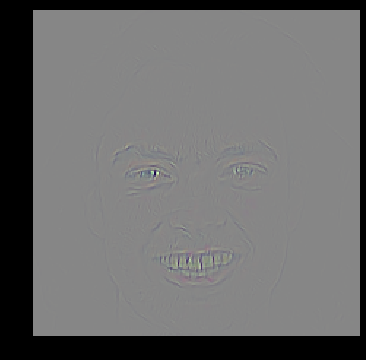

In [ ]:
guided_grad.show(figsize=(6,6))

For better visualization, lets highlight the most relevant areas of the image, we will multiply this by the heatmap computed from Grad-CAM.

In [ ]:
gbp = guided_grad.data.cpu().numpy()

In [ ]:
gbp.shape, hmap.shape

((3, 224, 224), (224, 224))

In [ ]:
hl_gbp = np.einsum('ijk,jk->jk',gbp,hmap)

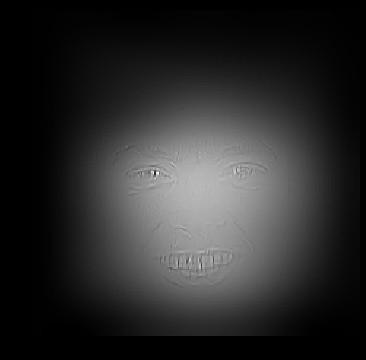

In [ ]:
Image(pil2tensor(hl_gbp, np.float32)).show(figsize=(6,6), cmap='gray')

Hooray! Now we have it. Let's move on for refactoring.

## EON

## Refactor

In [ ]:
#export
from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage

In [ ]:
#from fasterai.gramcm import * 

In [ ]:
%%timeit
grad_cam = GradCam.from_one_img(learn,img)

In [ ]:
#export
class GradCam():
    def __init__(self,img,lbl,prob,hmap,grad):
        self.img = img
        self.lbl = lbl
        self.prob = prob
        self.hmap = hmap
        self.grad = grad
        
    @classmethod
    def from_one_img(cls,learn,img):
        # setup
        pred_lbl,pred_id,probs = learn.predict(img)
        xb,_   = learn.data.one_item(img)
        xb_im  = Image(learn.data.denorm(xb)[0])
        prob   = probs[pred_id].item()
        
        # calculate heatmap and guided backprop
        #import ipdb; ipdb.set_trace()
        hmap,grad = get_grad_heatmap(learn,xb,pred_id,size=xb_im.shape[-1])
        return cls(xb_im,pred_lbl,prob,hmap,grad)
        
    @classmethod
    def from_interp():
        pass
     
    def plot(self,plot_hmap=True,plot_grad=True):
        pass